### Loading the dataset

In [60]:
import pandas as pd

data = pd.read_csv("Copy of bankruptcy-prevention.csv",sep=';' )

data.head()

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
0,0.5,1.0,0.0,0.0,0.0,0.5,bankruptcy
1,0.0,1.0,0.0,0.0,0.0,1.0,bankruptcy
2,1.0,0.0,0.0,0.0,0.0,1.0,bankruptcy
3,0.5,0.0,0.0,0.5,0.0,1.0,bankruptcy
4,1.0,1.0,0.0,0.0,0.0,1.0,bankruptcy


In [61]:
df = data.copy()

## EDA

### Data cleaning

##### Checking if there are missing values or not

In [62]:
df.isnull().sum()

,0
industrial_risk,0
management_risk,0
financial_flexibility,0
credibility,0
competitiveness,0
operating_risk,0
class,0


##### checking if there are invalid values or not

In [63]:
cols = list(df.columns)
cols.remove(' class')

In [64]:
allowed = {0, 0.5, 1}
# loop over columns and find invalid entries
for col in cols:
    # all unique values not in allowed set
    invalid_vals = set(df[col].dropna().unique()) - allowed
    if invalid_vals:
        print(f" {col}: invalid values → {sorted(invalid_vals)}")
    else:
        print(f" {col}: no invalid values")

 industrial_risk: no invalid values
  management_risk: no invalid values
  financial_flexibility: no invalid values
  credibility: no invalid values
  competitiveness: no invalid values
  operating_risk: no invalid values


there are no invalid values present in dataset

##### Verifying Level Ordering

In [65]:
for col in cols:
    df[col] = pd.Categorical(df[col], categories=[0,0.5,1], ordered=True)

### UniVariate Analysis

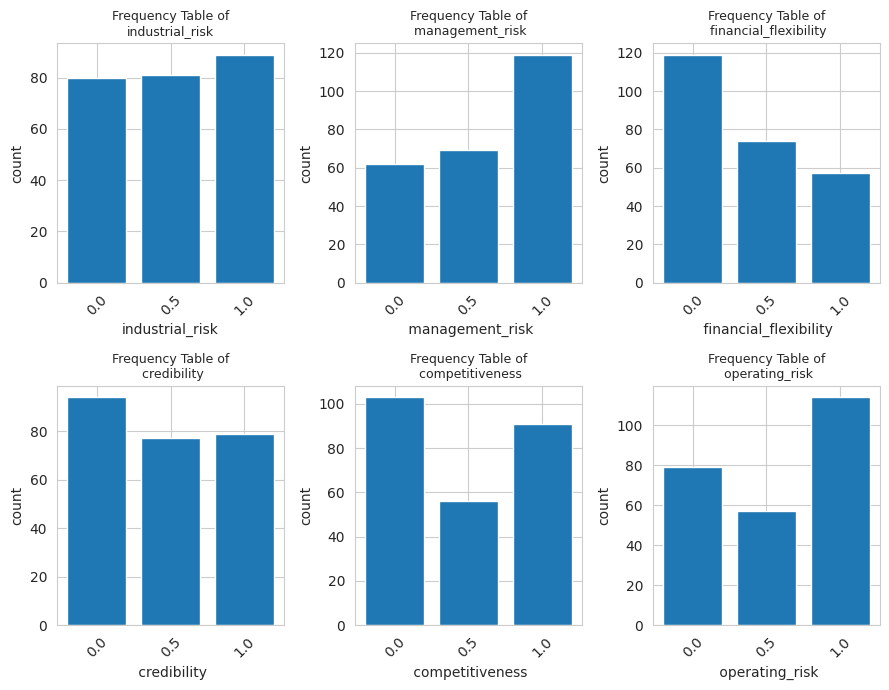

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,7))
for i, col in enumerate(cols):
    plt.subplot(2,3,i+1)
    freq = df[col].value_counts().sort_index()
    plt.bar(freq.index.astype(str), freq.values)
    plt.title(f'Frequency Table of\n{col}', fontsize=9)  # also split the title on two lines
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('count')

plt.tight_layout()
plt.show()


#### Insights based on Frequency Table or Bar plot

##### 1.) Most of the companies have high management risks and high operating risks
##### 2.) Many companies struggle with debt and access funding because of low financial_flexibility
##### 3.) Low Competitivenes and low credibility

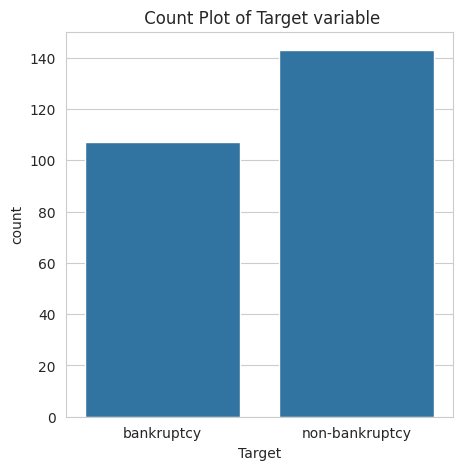

In [67]:
plt.figure( figsize=(5,5))
sns.countplot(x = df[ ' class'])
plt.title(" Count Plot of Target variable")
plt.xlabel('Target')
plt.ylabel('count')
plt.show()

## Bivariate Analysis

#### Cross Tabulation

In [68]:
ct = pd.DataFrame()
for col in cols:
    ct = pd.crosstab(df[col], df[' class'],margins=True,margins_name="Total")


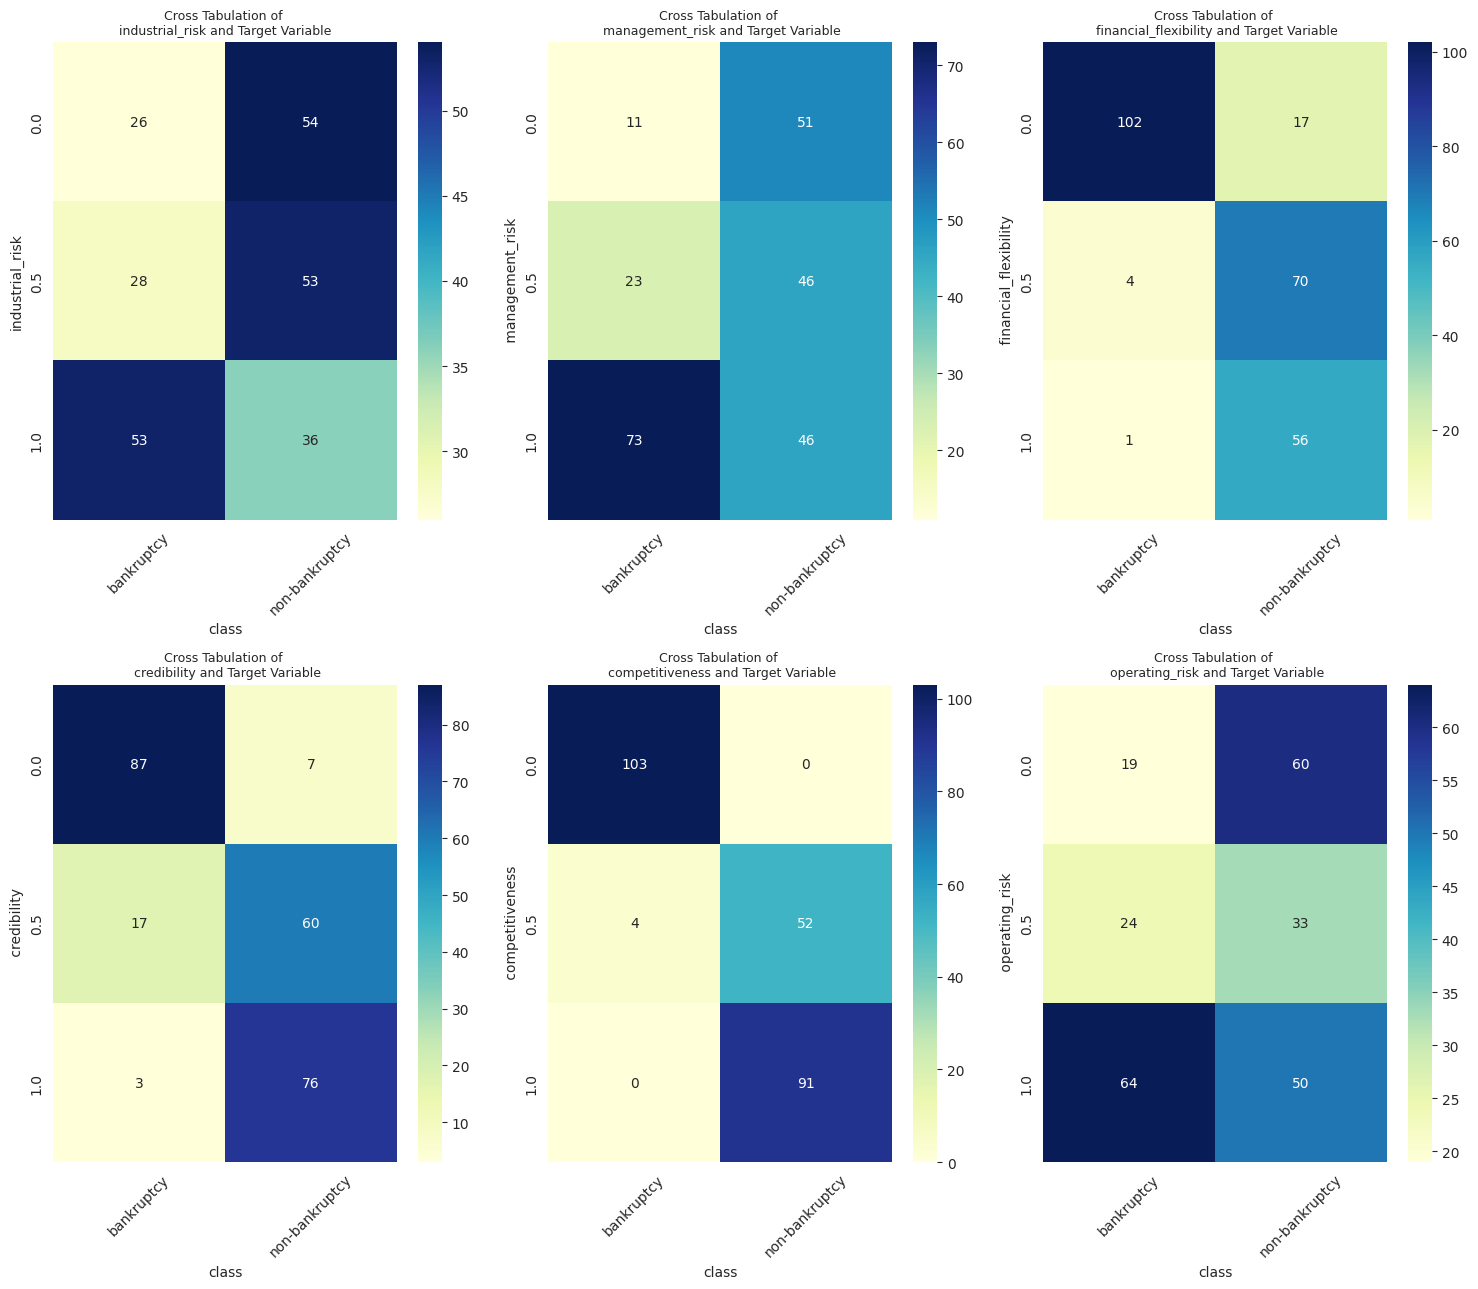

In [69]:
plt.figure(figsize=(15,13))
for i, col in enumerate(cols):
    plt.subplot(2,3,i+1)
    ct = pd.crosstab(df[col], df[' class'])
    sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
    plt.xticks(rotation=45)
    plt.title(f"Cross Tabulation of \n{col} and Target Variable",fontsize=9)
    plt.xlabel( 'class')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

### 100% Stacked Bar plot

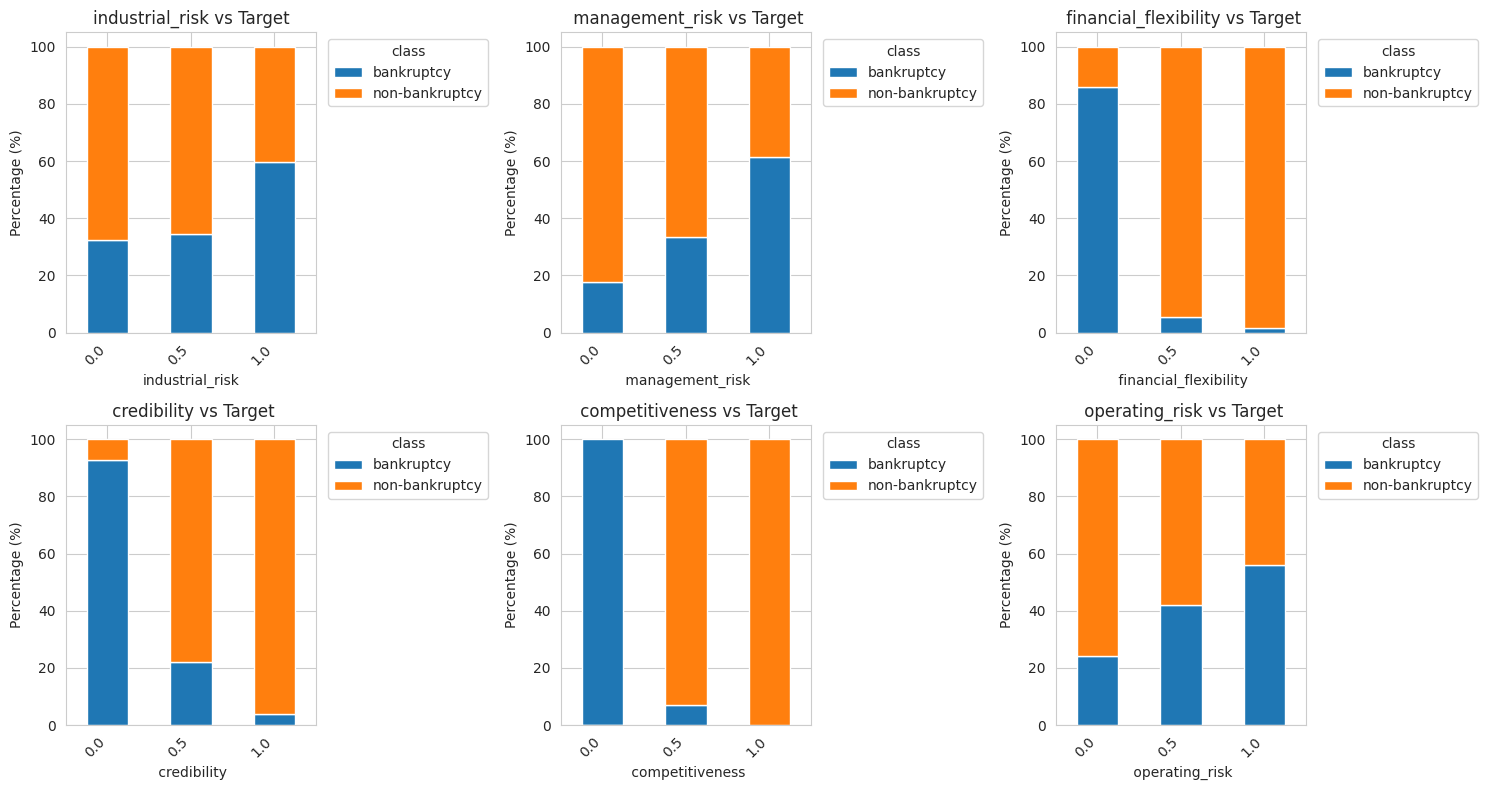

In [70]:
# Create a 100% stacked bar plot for each categorical variable
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
axes = axes.flatten()  # so we can index with a single counter
# 4. Loop and plot into each subplot
for ax, col in zip(axes, cols):
    # Compute 100%‑normalized crosstab
    crosstab = pd.crosstab(df[col], df[' class'], normalize='index') * 100

    # Plot onto the specific axis
    crosstab.plot(
        kind='bar',
        stacked=True,
        ax=ax
    )
    ax.set_title(f'{col} vs Target')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel(col)

    # Move the legend outside each subplot
    ax.legend(
        title='class',
        bbox_to_anchor=(1.02, 1),
        loc='upper left'
    )
    # rotate x‑ticks if needed
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 5. Turn off any unused subplots (if len(cols) < 6)
for idx in range(len(cols), nrows * ncols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


#### Insights based on 100% stacked barplot

##### 1.) 100% of Low competitiveness companies are gone bankrupt, 100% of high competitive companies are not gone bankrupt. so, competitiveness is more corelated variable.
##### 2.) Companies with low credibility and financial_flexibility are gone bankrupt
##### 3.) At Low risk, only ~20 – 25% of firms go bankrupt, but at High risk that share jumps to 60 – 80%.



### Trend test using Spearmen's p

In [71]:
from scipy.stats import spearmanr
import numpy as np # Import numpy

# Encode binary target
df['class_Encoded'] = df[' class'].map({'bankruptcy': 1, 'non-bankruptcy': 0}).astype('int64')

results = []
for col in cols:
    # Convert categorical features to float for spearmanr
    # Convert target variable to numpy array of floats
    rho, pval = spearmanr(df[col].astype('float'), np.asarray(df['class_Encoded'], dtype=float))
    results.append({
        'Feature': col,
        'Correlation': rho,
        'p-value': pval
    })

results_df = pd.DataFrame(results)

print(results_df.to_markdown(index=False, floatfmt=".4f"))

| Feature               |   Correlation |   p-value |
|:----------------------|--------------:|----------:|
| industrial_risk       |        0.2295 |    0.0003 |
| management_risk       |        0.3744 |    0.0000 |
| financial_flexibility |       -0.7830 |    0.0000 |
| credibility           |       -0.7619 |    0.0000 |
| competitiveness       |       -0.9060 |    0.0000 |
| operating_risk        |        0.2784 |    0.0000 |


#### Visualization of Trend test using Spearmen's p

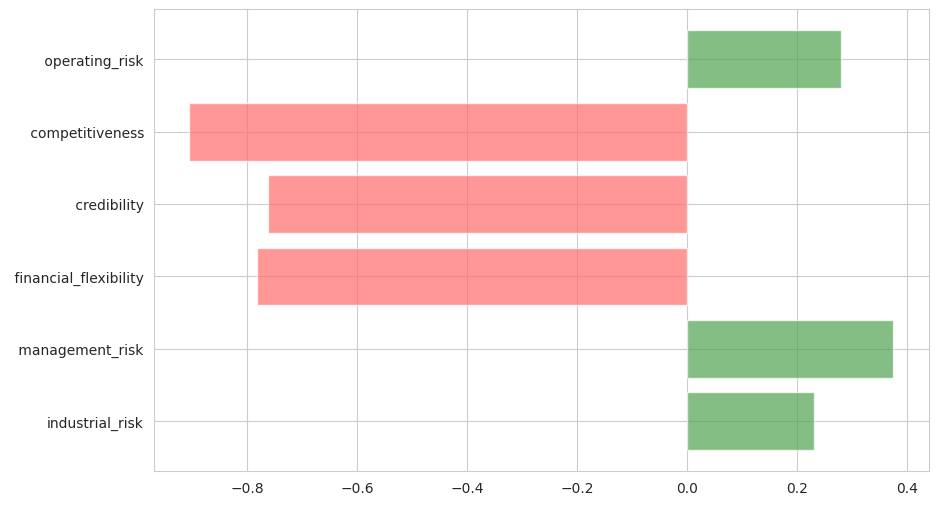

In [72]:
# 2. Create the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Color palette (red for negative, green for positive)
colors = ['#FF6B6B' if x < 0 else '#51A351' for x in results_df['Correlation']]

# Bar plot
bars = plt.barh(results_df['Feature'], results_df['Correlation'], color=colors, alpha=0.7)

##### 1.) All the Categorical Variables have monotonic relationship with target variable
##### 2.) Competitiveness, financial_flexibility and credibility are strong predictors

### Heatmap of the data

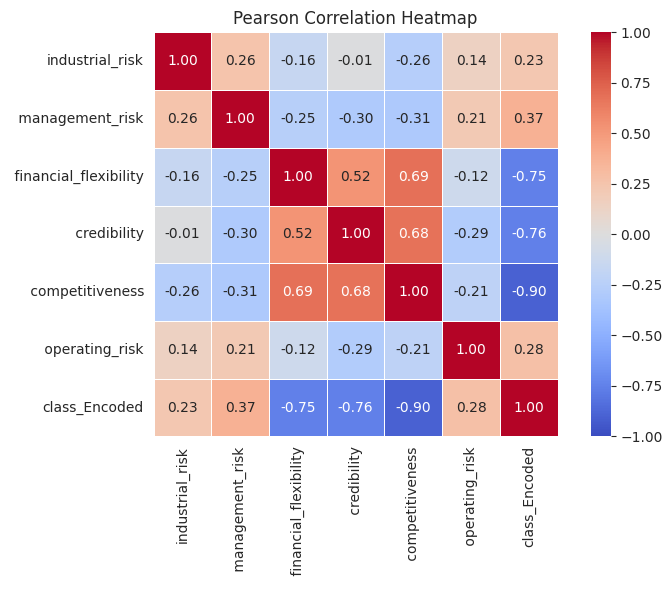

In [73]:
# Drop the original 'class' column before calculating correlation
df_numeric = df.drop(' class', axis=1)

corr = df_numeric.corr()

# 3. Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,      # show the correlation coefficients
    fmt='.2f',       # two decimals
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5
)
plt.title('Pearson Correlation Heatmap')
plt.tight_layout()
plt.show()

### Data Transformation

In [74]:
# Encode binary target
df['class_Encoded'] = df[' class'].map({'bankruptcy': 1, 'non-bankruptcy': 0}).astype('int64')

In [75]:
df.drop(' class',axis=1, inplace=True)

In [76]:
df.columns

Index(['industrial_risk', ' management_risk', ' financial_flexibility',
       ' credibility', ' competitiveness', ' operating_risk', 'class_Encoded'],
      dtype='object')

In [77]:
df

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class_Encoded
0,0.5,1.0,0.0,0.0,0.0,0.5,1
1,0.0,1.0,0.0,0.0,0.0,1.0,1
2,1.0,0.0,0.0,0.0,0.0,1.0,1
3,0.5,0.0,0.0,0.5,0.0,1.0,1
4,1.0,1.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...
245,0.0,1.0,1.0,1.0,1.0,1.0,0
246,1.0,1.0,0.5,1.0,1.0,0.0,0
247,0.0,1.0,1.0,0.5,0.5,0.0,0
248,1.0,0.0,0.5,1.0,0.5,0.0,0


In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay

In [80]:
#le = LabelEncoder()
#for col in df.columns:
#    if df[col].dtype == "object":
#        df[col] = le.fit_transform(df[col])

In [81]:
#  Split the dataset
X = df.drop("class_Encoded", axis=1)
y = df["class_Encoded"]

In [82]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [84]:
# Helper function to plot confusion matrix
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [85]:
# Helper function to plot ROC curve
def plot_roc_curve(model_name, y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [86]:
# 1. Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)

🔍 Logistic Regression


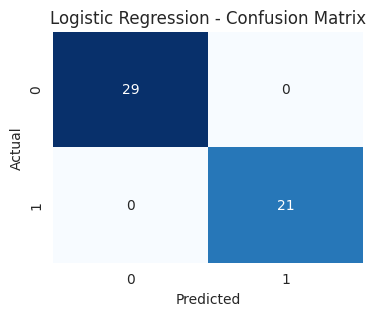

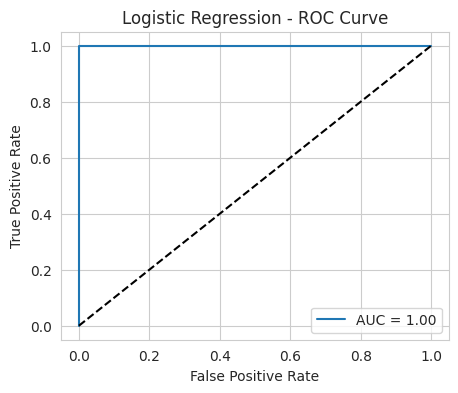

In [87]:
# Logistic Regression Visualizations
print("🔍 Logistic Regression")
plot_confusion_matrix("Logistic Regression", y_test, log_pred)
plot_roc_curve("Logistic Regression", y_test, log_model.predict_proba(X_test)[:, 1])

In [88]:
# 2. Decision Tree
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_acc = accuracy_score(y_test, tree_pred)


🔍 Decision Tree


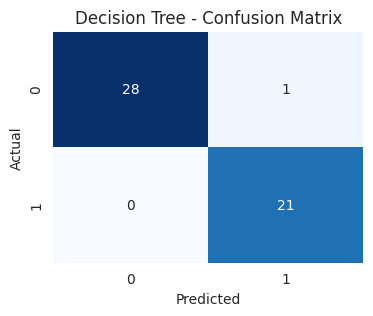

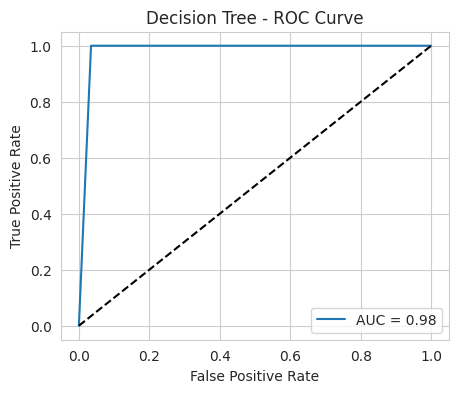

In [89]:
# Decision Tree Visualizations
print("🔍 Decision Tree")
plot_confusion_matrix("Decision Tree", y_test, tree_pred)
plot_roc_curve("Decision Tree", y_test, tree_model.predict_proba(X_test)[:, 1])


In [90]:
# 3. Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

🔍 Random Forest


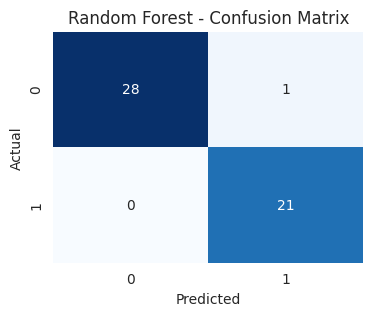

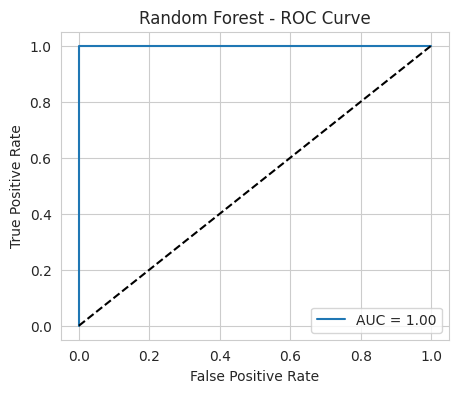

In [91]:
# Random Forest Visualizations
print("🔍 Random Forest")
plot_confusion_matrix("Random Forest", y_test, rf_pred)
plot_roc_curve("Random Forest", y_test, rf_model.predict_proba(X_test)[:, 1])


In [92]:
# 4. Linear Regression (treating as classification by thresholding)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)
lin_pred_class = np.where(lin_pred > 0.5, 1, 0)
lin_acc = accuracy_score(y_test, lin_pred_class)

🔍 Linear Regression (thresholded)


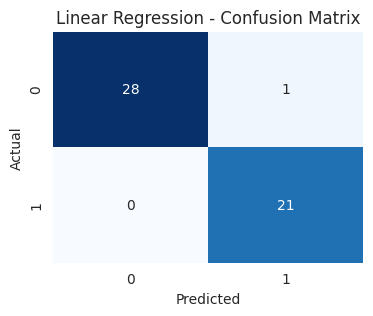

In [93]:
# Linear Regression Visualization
print("🔍 Linear Regression (thresholded)")
plot_confusion_matrix("Linear Regression", y_test, lin_pred_class)

In [94]:
#  Print results
print("📊 Model Performance:")
print(f"Logistic Regression Accuracy     : {log_acc:.2f}")
print(f"Decision Tree Accuracy           : {tree_acc:.2f}")
print(f"Random Forest Accuracy           : {rf_acc:.2f}")
print(f"Linear Regression Accuracy       : {lin_acc:.2f}")


📊 Model Performance:
Logistic Regression Accuracy     : 1.00
Decision Tree Accuracy           : 0.98
Random Forest Accuracy           : 0.98
Linear Regression Accuracy       : 0.98


In [95]:
#  Pick the best model
accuracies = {
    "Logistic Regression": log_acc,
    "Decision Tree": tree_acc,
    "Random Forest": rf_acc,
    "Linear Regression": lin_acc
}
best_model = max(accuracies, key=accuracies.get)
print(f"\n✅ Best model: {best_model} with accuracy of {accuracies[best_model]:.2f}")


✅ Best model: Logistic Regression with accuracy of 1.00


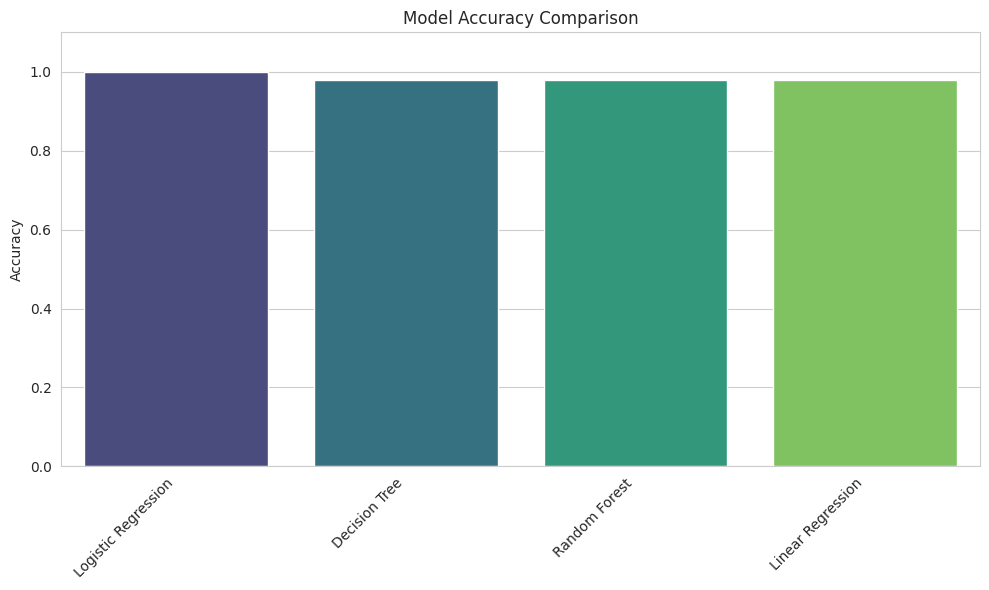

In [96]:
# Create a bar plot of model accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='viridis', hue=list(accuracies.keys()), legend=False)
plt.ylim(0, 1.1) # Set y-axis limits from 0 to 1.1 for better visualization of accuracy
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

# **Model Evaluation**

In [97]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import numpy as np
import pandas as pd

In [98]:
results = []

# 1. Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_proba = log_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, log_pred),
    "Precision": precision_score(y_test, log_pred),
    "Recall": recall_score(y_test, log_pred),
    "F1 Score": f1_score(y_test, log_pred),
    "ROC AUC": roc_auc_score(y_test, log_proba)
})

# 2. Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_proba = dt_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, dt_pred),
    "Precision": precision_score(y_test, dt_pred),
    "Recall": recall_score(y_test, dt_pred),
    "F1 Score": f1_score(y_test, dt_pred),
    "ROC AUC": roc_auc_score(y_test, dt_proba)
})

# 3. Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, rf_pred),
    "Precision": precision_score(y_test, rf_pred),
    "Recall": recall_score(y_test, rf_pred),
    "F1 Score": f1_score(y_test, rf_pred),
    "ROC AUC": roc_auc_score(y_test, rf_proba)
})

# 4. Linear Regression (used as classifier)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred_continuous = lin_model.predict(X_test)
lin_proba = np.clip(lin_pred_continuous, 0, 1)
lin_pred = np.where(lin_proba > 0.5, 1, 0)
results.append({
    "Model": "Linear Regression (thresholded)",
    "Accuracy": accuracy_score(y_test, lin_pred),
    "Precision": precision_score(y_test, lin_pred),
    "Recall": recall_score(y_test, lin_pred),
    "F1 Score": f1_score(y_test, lin_pred),
    "ROC AUC": roc_auc_score(y_test, lin_proba)
})

In [99]:
results_df = pd.DataFrame(results).set_index("Model")
print("\nModel Evaluation Results:\n")
print(results_df)


Model Evaluation Results:

                                 Accuracy  Precision  Recall  F1 Score  \
Model                                                                    
Logistic Regression                  1.00   1.000000     1.0  1.000000   
Decision Tree                        0.98   0.954545     1.0  0.976744   
Random Forest                        0.98   0.954545     1.0  0.976744   
Linear Regression (thresholded)      0.98   0.954545     1.0  0.976744   

                                  ROC AUC  
Model                                      
Logistic Regression              1.000000  
Decision Tree                    0.982759  
Random Forest                    1.000000  
Linear Regression (thresholded)  1.000000  


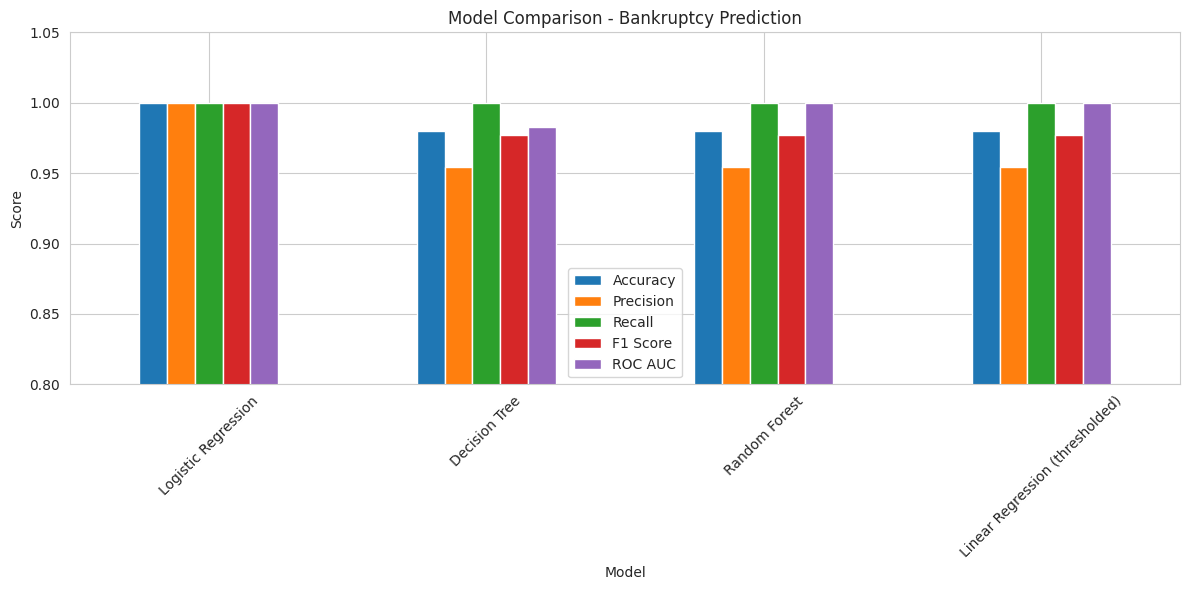

In [100]:
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison - Bankruptcy Prediction")
plt.ylabel("Score")
plt.ylim(0.8, 1.05)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Best Model**

In [101]:
best_model_name = results_df['F1 Score'].idxmax()
best_model_data = results_df.loc[best_model_name]

print(f"\nBased on F1 Score, the best model is: {best_model_name}")
print("\nMetrics for the Best Model:")
print(best_model_data)

# Access the actual best model object
if best_model_name == "Logistic Regression":
    best_model = log_model
elif best_model_name == "Decision Tree":
    best_model = dt_model
elif best_model_name == "Random Forest":
    best_model = rf_model
elif best_model_name == "Linear Regression (thresholded)":
     best_model = lin_model # Note: This is the Linear Regression model, not a thresholded version for this variable.

print(f"\nThe best model object is: {best_model}")


Based on F1 Score, the best model is: Logistic Regression

Metrics for the Best Model:
Accuracy     1.0
Precision    1.0
Recall       1.0
F1 Score     1.0
ROC AUC      1.0
Name: Logistic Regression, dtype: float64

The best model object is: LogisticRegression()


In [102]:
# model evaluation summary

print(results_df.to_markdown(floatfmt=".4f"))


| Model                           |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|:--------------------------------|-----------:|------------:|---------:|-----------:|----------:|
| Logistic Regression             |     1.0000 |      1.0000 |   1.0000 |     1.0000 |    1.0000 |
| Decision Tree                   |     0.9800 |      0.9545 |   1.0000 |     0.9767 |    0.9828 |
| Random Forest                   |     0.9800 |      0.9545 |   1.0000 |     0.9767 |    1.0000 |
| Linear Regression (thresholded) |     0.9800 |      0.9545 |   1.0000 |     0.9767 |    1.0000 |


# **Model Deployment**

In [103]:
import pickle
from google.colab import files

# Save the trained logistic regression model
with open("logistic_regression.pkl", "wb") as f:
    pickle.dump(log_model, f)

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save the columns
with open("columns.pkl", "wb") as f:
    pickle.dump(X.columns, f)

# Download the saved files
files.download("logistic_regression.pkl")
files.download("scaler.pkl")
files.download("columns.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>